# Example of station forecasts postprocessing

In this example, using Pythie, we postprocess the 2 metre temperature forecasts at a station. We postprocess it with the 2 metre temperature itself, the maximum 2 metre temperature in the last 6 hours and the soil temperature as predictors.

We use the observation data of the [WMO](https://public.wmo.int/en)-compliant [DWD](https://www.dwd.de) meteorological station of [Soltau](https://en.wikipedia.org/wiki/Soltau) from 1997 to 2016.
The station is located at the point [52°57'37.5"N, 9°47'35.0"E](https://www.google.com/maps/place/52%C2%B057'37.5%22N+9%C2%B047'35.0%22E/@52.9507203,9.7805715,14.5z). The data have been downloaded from the DWD [Climate Data Center](https://cdc.dwd.de/portal/).

The postprocessing is done by making a regression at each lead time between the reforecasts at a nearby (5.3 km) grid point [53°00'00.0"N, 9°45'00.0"E](https://www.google.com/maps/place/53%C2%B000'00.0%22N+9%C2%B045'00.0%22E/@53.0205719,9.7147325,12.25z). For verification, the result of this regression is then applied on the reforecasts themselves (the training set).

The reforecasts at the grid point have been extracted from the reforecasts gridded data available in the gridded reforecasts and reanalysis dataset.

**Note:** *In the following example, we drop the initial conditions of the reforecasts because one of the maximum 2 meter temperature is not defined at this lead time ! As a result, we do not postprocess the lead time 0.*

**Observation data source**

Source: [Deutscher Wetterdienst](https://www.dwd.de/), [DWD CDC portal](https://cdc.dwd.de/portal/)

**Reforecast data source**

Source: [www.ecmwf.int](https://www.ecmwf.int/)

Creative Commons Attribution 4.0 International (CC BY 4.0)
Copyright © 2021 European Centre for Medium-Range Weather Forecasts (ECMWF).
See the attached ECMWF_LICENSE.txt file included with the data for more details.

## Preliminaries

Setting the path

In [1]:
import sys, os
sys.path.extend([os.path.abspath('../../../../')])
os.chdir('../../../../')

Importing external modules

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
from matplotlib import rc
rc('font',**{'family':'serif','sans-serif':['Times'],'size':16})

Importing internal modules

In [4]:
from core.data import Data
import postprocessors.MBM as MBM


Setting some parameters

In [5]:
# Date of the forecast
date = "01-02"
# Year to correct
year = 2017
# Number of reforecasts
years_back = 20
# Parameter of the observations (to be postprocessed)
param = '2t'
# Parameters of the predictors
params = ['2t', 'mx2t6', 'stl1']
# Locaction of the data
data_folder = './data/soltau/'
# Station considered
station = 4745

## Loading and creating the Data objects

**This section shows how to load Data objects from csv files using pandas**

Loading the reforecast data

In [6]:
# Temperature
# First create a list of pandas Dataframes from the csv files
reforecasts_temp = list()
for y in range(year-years_back, year):
    # note : we skip the first row to drop the forecast initial condition
    reforecasts_temp.append(pd.read_csv(data_folder + 'reforecasts_2t_' + str(y) + '-' + date + '_' + str(station) + '.csv', index_col=0, parse_dates=True, skiprows=[1]))
# Then a Data object from this list, loading it along the observation axis, and each member of the list along the member axis
reforecasts_data_2t = Data()
reforecasts_data_2t.load_scalars(reforecasts_temp, load_axis=['obs', 'member'], columns='all')
reforecasts_data_list = list()
reforecasts_data_list.append(reforecasts_data_2t)

In [7]:
# Same for the maximum temperature over the last 6 hours
reforecasts_data_mx2t6 = Data()
reforecasts_mx2t6 = list()
for y in range(year-years_back, year):
    # note : we skip the first row to drop the forecast initial condition
    reforecasts_mx2t6.append(pd.read_csv(data_folder + 'reforecasts_mx2t6_' + str(y) + '-' + date + '_' + str(station) + '.csv', index_col=0, parse_dates=True, skiprows=[1]))
reforecasts_data_mx2t6.load_scalars(reforecasts_mx2t6, load_axis=['obs', 'member'], columns='all')
reforecasts_data_list.append(reforecasts_data_mx2t6)

In [8]:
# Same for the soil temperature
reforecasts_data_stl1 = Data()
reforecasts_stl1 = list()
for y in range(year-years_back, year):
    # note : we skip the first row to drop the forecast initial condition
    reforecasts_stl1.append(pd.read_csv(data_folder + 'reforecasts_stl1_' + str(y) + '-' + date + '_' + str(station) + '.csv', index_col=0, parse_dates=True, skiprows=[1]))
reforecasts_data_stl1.load_scalars(reforecasts_stl1, load_axis=['obs', 'member'], columns='all')
reforecasts_data_list.append(reforecasts_data_stl1)

In [9]:
# saving the first predictor (the variable itself) for latter
reforecast_data_1st_predictor = reforecasts_data_list[0].copy()

# Then loading all the predictors into one single Data object
reforecasts_data = reforecasts_data_list[0].copy()
for reforecast in reforecasts_data_list[1:]:
    reforecasts_data.append_predictors(reforecast)

Loading the observations corresponding to the reforecast data

In [10]:
# skipping the initial condition of the forecast and taking 6-hourly observations to match the reforecasts timestep
skiprows = lambda x: x==1 or (x != 0 and (x-1) % 6 != 0)
# Temperature
# First create a list of pandas Dataframes from the csv files
past_obs_temp = list()
for y in range(year-years_back, year):
    past_obs_temp.append(pd.read_csv(data_folder + 'past_observations_2t_' + str(y) + '-' + date + '_' + str(station) + '.csv', index_col=0, parse_dates=True, skiprows=skiprows))
# Then a Data object from this list, loading it along the observation axis, and each member of the list along the member axis
past_obs_data = Data()
for obs in past_obs_temp:
    past_obs_data.load_scalars(obs, load_axis='obs', columns='2t', concat_axis='obs')


## Training the PostProcessors

In this section, we train the various different postprocessors of the Member-By-Member MBM module with the data previously loaded

In [11]:
# List to hold the trained PostProcessors
postprocessors = list()
proc_labels = list()

### Simple bias correction

In [12]:
ebc = MBM.BiasCorrection()
ebc.train(past_obs_data, reforecasts_data)
postprocessors.append(ebc)
proc_labels.append('Bias correction')


### Ensemble Mean correction

In [13]:
emc = MBM.EnsembleMeanCorrection()
emc.train(past_obs_data, reforecasts_data)
postprocessors.append(emc)
proc_labels.append('Ensemble Mean correction')


### Ensemble Spread Scaling correction

In [14]:
essc = MBM.EnsembleSpreadScalingCorrection()
essc.train(past_obs_data, reforecasts_data)
postprocessors.append(essc)
proc_labels.append('Ensemble Spread Scaling correction')


### Ensemble Spread Scaling correction with Absolute norm CRPS minimization

In [15]:
essacc = MBM.EnsembleSpreadScalingAbsCRPSCorrection()
essacc.train(past_obs_data, reforecasts_data, ntrial=10)
postprocessors.append(essacc)
proc_labels.append('Ensemble Spread Scaling Abs. CRPS min. correction')


### Ensemble Spread Scaling correction + Climatology nudging with Absolute norm CRPS minimization

In [16]:
eacc = MBM.EnsembleAbsCRPSCorrection()
eacc.train(past_obs_data, reforecasts_data, ntrial=10)
postprocessors.append(eacc)
proc_labels.append('Ensemble Spread Scaling + Clim. Nudging Abs. CRPS min. correction')


### Ensemble Spread Scaling correction + Climatology nudging with Ngr CRPS minimization

In [17]:
encc = MBM.EnsembleNgrCRPSCorrection()
encc.train(past_obs_data, reforecasts_data, ntrial=10)
postprocessors.append(encc)
proc_labels.append('Ensemble Spread Scaling + Clim. Nudging Ngr CRPS min. correction')


## Verification

Here we are going to postprocess the reforecasts themselves to see how well they perform:

In [18]:
# List to store the experiment names
exp_results = list()
exp_results.append(reforecast_data_1st_predictor)
exp_labels = list()
exp_labels.append('Raw forecasts')

In [19]:
timestamps = np.array(range(reforecast_data_1st_predictor.number_of_time_steps))

In [20]:
for label, postprocessor in zip(proc_labels, postprocessors):
    exp_results.append(postprocessor(reforecasts_data))
    exp_labels.append(label)


### Computing scores

Computing the bias

In [21]:
# List to store the CRPS Data object
bias = list()
for label, result in zip(exp_labels, exp_results):
    bias.append(result.bias(past_obs_data))

Computing the ensemble mean RMSE

In [22]:
# List to store the CRPS Data object
rmse = list()
for label, result in zip(exp_labels, exp_results):
    rmse.append(result.ensemble_mean_RMSE(past_obs_data))

Computing the CRPS

In [23]:
# List to store the CRPS Data object
crps = list()
for label, result in zip(exp_labels, exp_results):
    crps.append(result.CRPS(past_obs_data))

### Plotting the scores

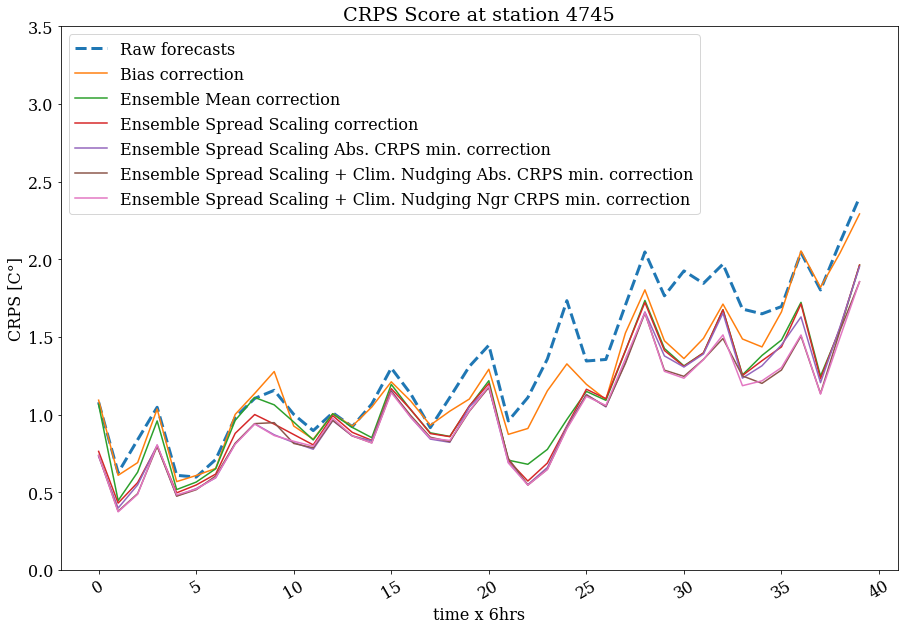

In [24]:
fig = plt.figure(figsize=(15,10))
ax = fig.gca()

first = True
for c, lab in zip(crps, exp_labels):
    if first:
        c.plot(ax=ax, global_label=lab, timestamps=timestamps, lw=3., ls="--")
        first = False
    else:
        c.plot(ax=ax, global_label=lab, timestamps=timestamps)

ax.legend()
ax.set_title('CRPS Score at station '+str(station))
ax.set_ylabel('CRPS [C°]')
ax.set_xlabel('time x 6hrs');
ax.set_ylim(0., 3.5);

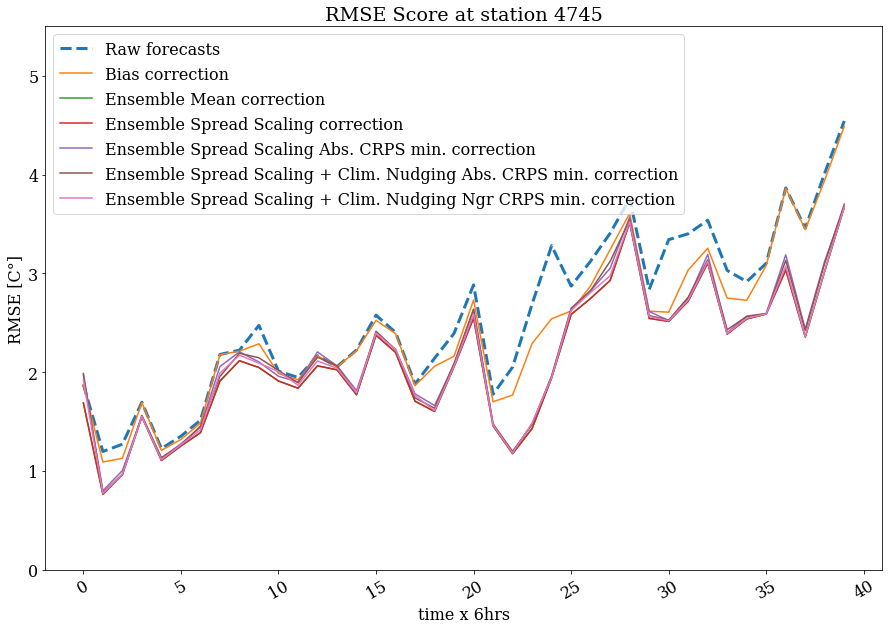

In [25]:
fig = plt.figure(figsize=(15,10))
ax = fig.gca()

first = True
for c, lab in zip(rmse, exp_labels):
    if first:
        c.plot(ax=ax, global_label=lab, timestamps=timestamps, lw=3., ls="--")
        first = False
    else:
        c.plot(ax=ax, global_label=lab, timestamps=timestamps)

ax.legend()
ax.set_title('RMSE Score at station '+str(station))
ax.set_ylabel('RMSE [C°]')
ax.set_xlabel('time x 6hrs');
ax.set_ylim(0., 5.5);

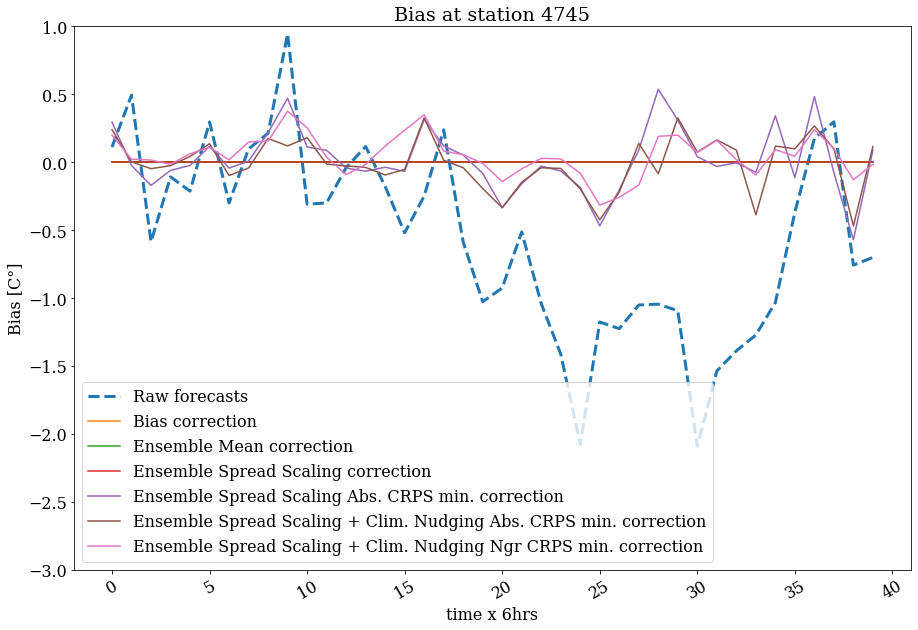

In [26]:
fig = plt.figure(figsize=(15,10))
ax = fig.gca()

first = True
for c, lab in zip(bias, exp_labels):
    if first:
        c.plot(ax=ax, global_label=lab, timestamps=timestamps, lw=3., ls="--")
        first = False
    else:
        c.plot(ax=ax, global_label=lab, timestamps=timestamps)

ax.legend()
ax.set_title('Bias at station '+str(station))
ax.set_ylabel('Bias [C°]')
ax.set_xlabel('time x 6hrs');
ax.set_ylim(-3., 1.);

### Example of a postprocessing parameters plot

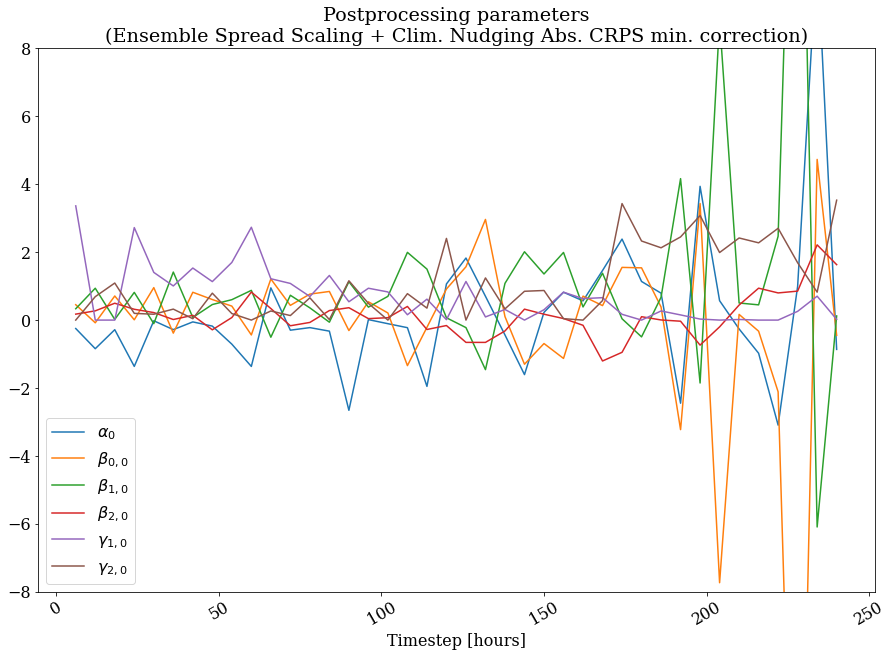

In [27]:
fig = plt.figure(figsize=(15,10))
ax = fig.gca()
postprocessors[-2].plot_parameters(ax=ax);
ax.set_ylim(-8.,8.)
ax.set_xlabel('Timestep [hours]')
ax.set_title('Postprocessing parameters\n('+exp_labels[-2]+')');

### Example of a reforecast plot

In [28]:
a = Data(reforecast_data_1st_predictor[0,-2][np.newaxis, np.newaxis,...], timestamps=[reforecast_data_1st_predictor.timestamps[0,-2]])
b = Data(exp_results[-1][0,-2][np.newaxis, np.newaxis,...], timestamps=[reforecast_data_1st_predictor.timestamps[0,-2]])
bb = Data(exp_results[-2][0,-2][np.newaxis, np.newaxis,...], timestamps=[reforecast_data_1st_predictor.timestamps[0,-2]])
c = Data(past_obs_data[0,-2][np.newaxis, np.newaxis,...], timestamps=[past_obs_data.timestamps[0,-2]])

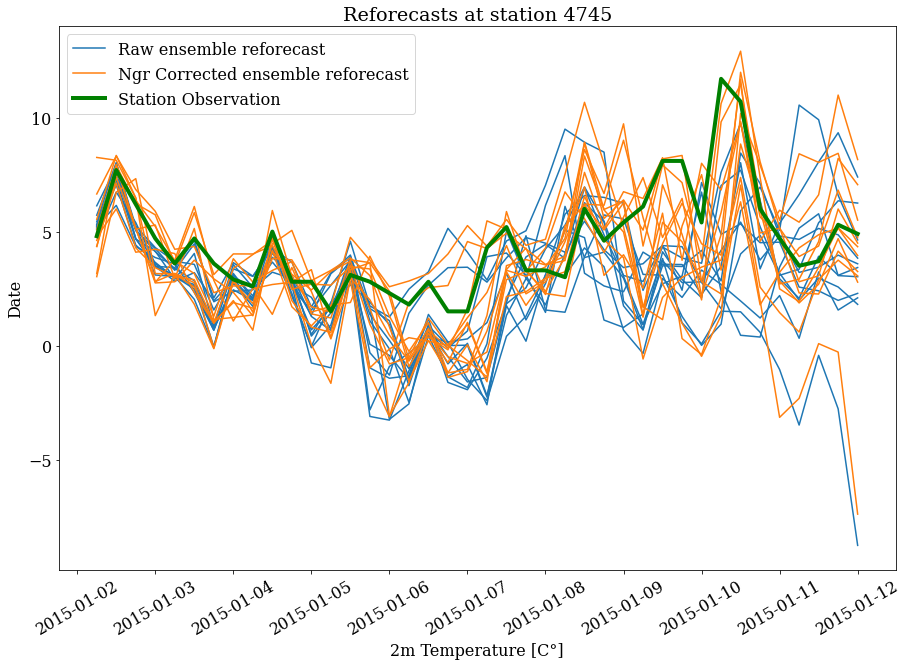

In [29]:
fig = plt.figure(figsize=(15,10))
ax = fig.gca()

a.plot(color='tab:blue', ax=ax, global_label='Raw ensemble reforecast')
b.plot(color='tab:orange', ax=ax, global_label='Ngr Corrected ensemble reforecast')
c.plot(color='g', ax=ax, label='Station Observation', lw=4.)
ax.set_title('Reforecasts at station '+str(station))
ax.set_ylabel('Date')
ax.set_xlabel('2m Temperature [C°]')
ax.legend();

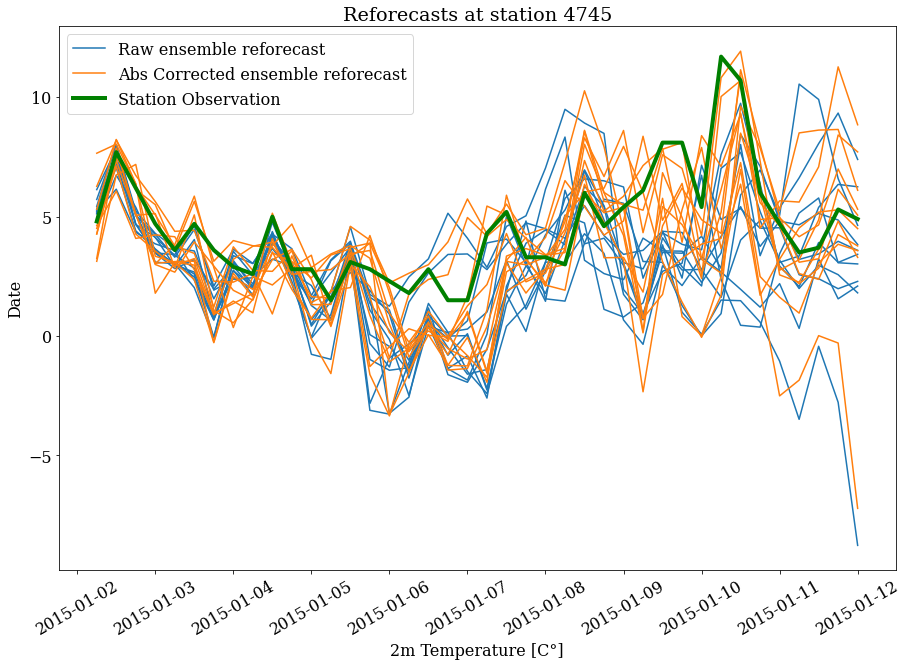

In [30]:
fig = plt.figure(figsize=(15,10))
ax = fig.gca()

a.plot(color='tab:blue', ax=ax, global_label='Raw ensemble reforecast')
bb.plot(color='tab:orange', ax=ax, global_label='Abs Corrected ensemble reforecast')
c.plot(color='g', ax=ax, label='Station Observation', lw=4.)
ax.set_title('Reforecasts at station '+str(station))
ax.set_ylabel('Date')
ax.set_xlabel('2m Temperature [C°]')
ax.legend();